**K-medoids algorithm**
<br>
<br>
In this example, we used the iris dataset, which consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor), resulting in 150 samples. Four features were measured from each sample: the length and the width of the sepals and petals, in centimetres.
<br>
<br>
The dataset can be downloaded in the following link: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data.

In [1]:
import os
import numpy as np
import math
from pyspark import SparkContext
from pyspark import SparkConf
sc = SparkContext.getOrCreate()

#Read file
filename = os.path.join("Data","iris.csv")
IrisRDD = sc.textFile(filename,8)
header = IrisRDD.take(1)[0]
print ("Campos disponíveis: {}".format(header))

#Headless
IrisHeadlessRDD = IrisRDD.filter(lambda x : x!=header)
firstObject = IrisHeadlessRDD.take(1)[0]
print (firstObject)

#Preprocessing
k=3 #number of clusters
n=4 #number of features
IrisPre = (IrisHeadlessRDD
          .map(lambda x: x.split(','))
          )    
IrisIni = (IrisPre
          .map(lambda x:  np.array([x[0], x[1], x[2], x[3]]))
          )
print IrisIni.take(1)
           
#Initial centroids
from numpy import inf
Centroids= IrisIni.takeSample(True, k, 1)
Costs=np.empty(k)
Costs.fill(inf)
Finish=False
Iter=0          
print Centroids
print Costs

Campos disponíveis: "sepal.length","sepal.width","petal.length","petal.width","variety"
5.1,3.5,1.4,.2,"Setosa"
[array([u'5.1', u'3.5', u'1.4', u'.2'],
      dtype='<U3')]
[array([u'4.8', u'3.4', u'1.9', u'.2'],
      dtype='<U3'), array([u'6.7', u'3', u'5', u'1.7'],
      dtype='<U3'), array([u'4.8', u'3.4', u'1.6', u'.2'],
      dtype='<U3')]
[ inf  inf  inf]


In [2]:
from scipy.spatial import distance
from scipy.spatial.distance import cdist

#Return the distance between two points
def DistPP(point1, point2):
    sumDist=0
    for i in range(0,n):
        pointA=toFloat(point1[i])
        pointB=toFloat(point2[i])
        sumDist=sumDist+((pointA-pointB)**2)
    return np.sqrt(sumDist)

#Return the centroid of a point
def Cluster(point, Centroids):
    mini=0
    for i in range(1,k):
        if DistPP(Centroids[mini], point) > DistPP(Centroids[i], point):
            mini=i
    return mini  

#Convert numeric to float
def toFloat(x):
    try:
        return float(x)
    except(ValueError, TypeError):
        return   0.0

In [8]:
from  operator import add
while Finish==False or Iter<=10:
    Iter=Iter+1
    #Determine the clusters and current cost
    IrisClusters = (IrisIni
               .map(lambda x:( Cluster(x, centroids), x))
                )
    IrisDistances = (IrisClusters
               .map(lambda x: (x[0], DistPP(Centroids[x[0]], x[1])))
               )
    Finish=True
    for i in range(0,k):
        #Separate the clusters
        Points=(IrisClusters
          .filter(lambda x: x[0]==i)
          .map(lambda x: x[1])
          .zipWithUniqueId()
          .map(lambda x: (x[1], x[0]))
          )
        #Combine the elements of the clusters to calculate the distances
        Combinations=Points.cartesian(Points)
        #Calculate the distance between each pair of elements of clusters
        Distances=(Combinations
            .map(lambda x: (x[0][0], DistPP(x[0][1],x[1][1])))
          )
        #Determine the cost of each element of the clusters
        SumCosts=(Distances
           .reduceByKey(add)
           )
        #Sort the costs in order to find the minimum costs
        Sorted=sorted(SumCosts.collect(), key=lambda x: x[1])
        #Define the new costs
        NewCost=Sorted[0][1]
        #Check if the algorithm terminates
        if NewCost<Costs[i]:
            Costs[i]=NewCost
            Finish=False
        #Find the id of the new centroids
        idNew=Sorted[0][0]
        newCentroid=(Points
             .filter(lambda x: x[0]==idNew)
        ).collect()[0][1]
        Centroids[i]=newCentroid


In [9]:
#Print the cluster assigned to each class
IrisClusters = (IrisPre
                .map(lambda x:( Cluster(np.array([x[0],x[1], x[2], x[3]]), Centroids), np.array([x[0],x[1], x[2], x[3]]), x[4]))
                )
SetosaCluster = sorted((IrisClusters
          .filter(lambda x: x[2] == '"Setosa"')
          .map(lambda x: ( x[0],1))
          .reduceByKey(add) 
        ).collect(), key= lambda x:x[1], reverse=True)[0][0]
VersicolorCluster = sorted((IrisClusters
          .filter(lambda x: x[2] == '"Versicolor"')
          .map(lambda x: ( x[0],1))
          .reduceByKey(add) 
        ).collect(), key= lambda x:x[1], reverse=True)[0][0]
VirginicaCluster = sorted((IrisClusters
          .filter(lambda x: x[2] == '"Virginica"')
          .map(lambda x: ( x[0],1))
          .reduceByKey(add) 
        ).collect(), key= lambda x:x[1], reverse=True)[0][0]
print SetosaCluster
print VersicolorCluster
print VirginicaCluster

2
0
1


In [10]:
#Check the results
CheckSetosaCluster=( IrisClusters
        .filter(lambda x: x[0]==SetosaCluster and x[2]=='"Setosa"')
       ).count()
CheckVersicolorCluster=( IrisClusters
        .filter(lambda x: x[0]==VersicolorCluster and x[2]=='"Versicolor"')
       ).count()
CheckVirginicaCluster=( IrisClusters
        .filter(lambda x: x[0]==VirginicaCluster and x[2]=='"Virginica"')
       ).count()
Total= IrisPre.count()
print float((CheckSetosaCluster+CheckVersicolorCluster+CheckVirginicaCluster))/float(Total)

0.906666666667


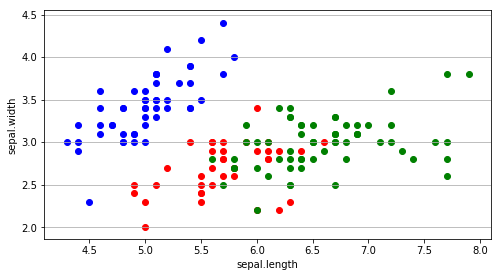

In [11]:
import matplotlib.pyplot as plt

#Plot the results considering the sepal features

Xlabel='sepal.length'
Ylabel='sepal.width'

Data0= IrisClusters.filter(lambda x: x[0]==0).map(lambda x: (float(x[1][0]), float(x[1][1]))).collect()
Data1= IrisClusters.filter(lambda x: x[0]==1).map(lambda x: (float(x[1][0]), float(x[1][1]))).collect()
Data2= IrisClusters.filter(lambda x: x[0]==2).map(lambda x: (float(x[1][0]), float(x[1][1]))).collect()


X0,Y0 = zip(*Data0)
X1,Y1 = zip(*Data1)
X2,Y2 = zip(*Data2)

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.scatter(X0,Y0, c='r')
plt.scatter(X1,Y1, c='g')
plt.scatter(X2,Y2, c='b')
plt.grid(b=True, which='major', axis='y')
plt.xlabel(Xlabel)
plt.ylabel(Ylabel)
plt.show()
pass

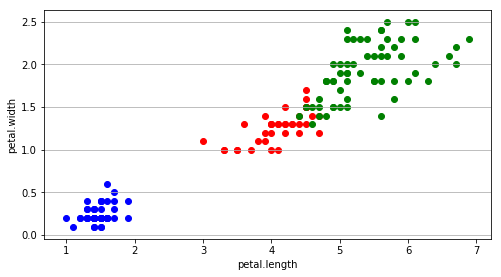

In [12]:
#Plot the results considering the petal features

X2label='petal.length'
Y2label='petal.width'

Data0_2= IrisClusters.filter(lambda x: x[0]==0).map(lambda x: (float(x[1][2]), float(x[1][3]))).collect()
Data1_2= IrisClusters.filter(lambda x: x[0]==1).map(lambda x: (float(x[1][2]), float(x[1][3]))).collect()
Data2_2= IrisClusters.filter(lambda x: x[0]==2).map(lambda x: (float(x[1][2]), float(x[1][3]))).collect()


X0_2,Y0_2 = zip(*Data0_2)
X1_2,Y1_2 = zip(*Data1_2)
X2_2,Y2_2 = zip(*Data2_2)

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.scatter(X0_2,Y0_2, c='r')
plt.scatter(X1_2,Y1_2, c='g')
plt.scatter(X2_2,Y2_2, c='b')
plt.grid(b=True, which='major', axis='y')
plt.xlabel(X2label)
plt.ylabel(Y2label)
plt.show()
pass